In [1]:
# %matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)


<module 'libs.params' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/params.py'>

In [2]:
import matplotlib
# matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


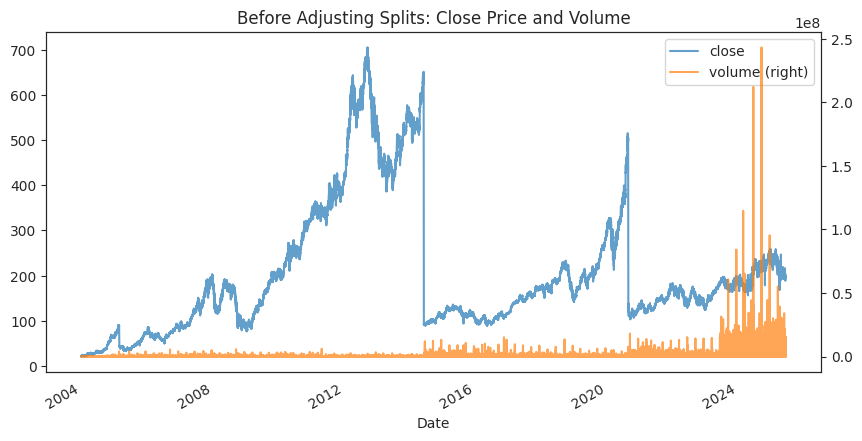

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


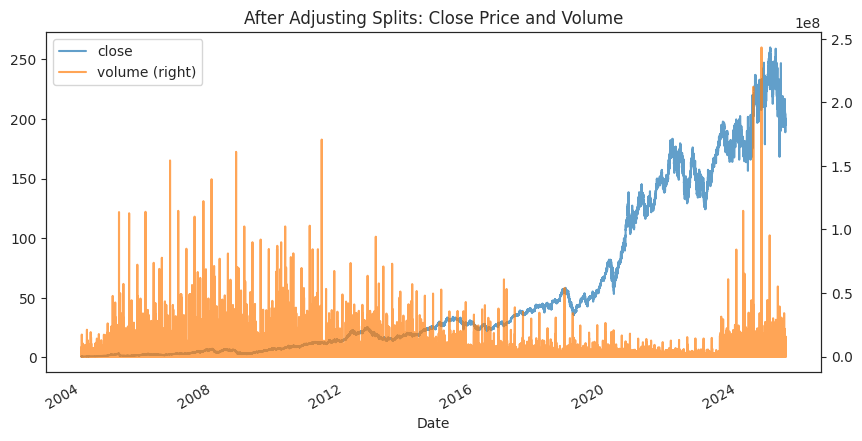

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.76505,0.763521
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.76505,0.763521
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.76505,0.763521
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.76505,0.763521
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.76505,0.763521
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,197.01180,196.618200
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.87170,196.478300
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.86670,196.473300
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.43620,196.043800


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 500
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder                   = params.stocks_folder,
    ticker                   = ticker,
    bidasktoclose_pct        = params.bidasktoclose_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df                    = df_raw,
    regular_start_shifted = params.regular_start_premarket, # regular_start_shifted,
    regular_start         = params.regular_start,
    regular_end           = params.regular_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    look_back,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    pre_entry_decay, 
    short_penal_decay,
    trailing_stop_pct,
    buy_threshold,
    top_percentile,
    smoothing_window
) -> float:
    """
     Run full backtest → one Strategy Return ($) per calendar day.
     Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
     Print both, return avg_daily_pnl to Optuna.
    """
    
    regular_start_pred = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back,
        60
    ))
    regular_start_shifted = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back*2,
        60
    ))

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal',
        col_action               = 'signal_action',
        min_prof_thr             = min_prof_thr,
        max_down_prop            = max_down_prop,
        gain_tightening_factor   = gain_tightening_factor,
        merging_retracement_thr  = merging_retracement_thr,
        merging_time_gap_thr     = merging_time_gap_thr,
        pre_entry_decay          = pre_entry_decay,
        short_penal_decay        = short_penal_decay,
        trailing_stop_pct        = trailing_stop_pct,
        buy_threshold            = buy_threshold,
        regular_start_shifted    = regular_start_shifted,
        top_percentile           = top_percentile,
        smoothing_window         = smoothing_window
    )

    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    # — use all trading days for the daily-P&L average —
    num_days      = len(simulation)

    del simulation
    gc.collect()

    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")
    
    return avg_daily_pnl


In [5]:
# calculate all possible look_backs, and create a list to use in the objective function,
# considering that it must be less than half time difference between regular_start and the first available timestamp

# 1) grab most common first timestamp’s time
first_times = df.index.to_series().groupby(df.index.normalize()).min().dt.time
first_time  = first_times.mode()[0]

# 2) convert to minutes since midnight
first_minutes   = first_time.hour * 60 + first_time.minute
start_minutes   = params.regular_start.hour * 60 + params.regular_start.minute

# 3) compute half the interval
diff_minutes  = start_minutes - first_minutes         # e.g. 14:30 − 11:30 = 330
half_minutes  = diff_minutes / 2                      # → 165.0

# 4) how many full 30-min chunks fit below half_minutes?
n_steps = int(half_minutes // 30)                     # floor(165/30) = 5

# 5) build list of multiples
look_backs = [30 * i for i in range(1, n_steps + 1)]   # → [30, 60, 90, 120, 150]




def objective(trial):
    hyperpars = {
        "look_back"               : trial.suggest_categorical("look_back", look_backs),
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.01, 0.2),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.01, 0.1),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.3, 3),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.01, 0.1),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.2, 1),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.1, 0.5),
        "short_penal_decay"       : trial.suggest_float("short_penal_decay", 0.3, 3),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.03, 0.9), 
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.01, 0.9),
        "top_percentile"          : trial.suggest_float("top_percentile", 1, 20),
        "smoothing_window"        : trial.suggest_categorical("smoothing_window", [1 ,2 ,3])
    }

    print('----------------------------------------------------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl

print('first_time', first_time)
print('look_backs', look_backs)

first_time 09:00:00
look_backs [30, 60, 90, 120, 150]


[I 2025-08-18 13:59:18,904] A new study created in RDB with name: no-name-d49ee4dc-5d8e-4178-a625-3cf1560a85f0


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:01:23,989] Trial 0 finished with value: 0.038515370370370366 and parameters: {'look_back': 30, 'min_prof_thr': 0.13565721745826276, 'max_down_prop': 0.0875532282121785, 'gain_tightening_factor': 2.908569491375252, 'merging_retracement_thr': 0.04411838026110706, 'merging_time_gap_thr': 0.7789929205776058, 'pre_entry_decay': 0.4644241433475451, 'short_penal_decay': 1.4103447281755033, 'trailing_stop_pct': 0.2622521616186917, 'buy_threshold': 0.8773754436838711, 'top_percentile': 2.893924511158902, 'smoothing_window': 2}. Best is trial 0 with value: 0.038515370370370366.


→ Total return across 5400 trading days: $207.98
→ Avg daily return (all days)          : $0.0385
→ Total trades                          : 25776
→ Avg return per trade                  : $0.0081



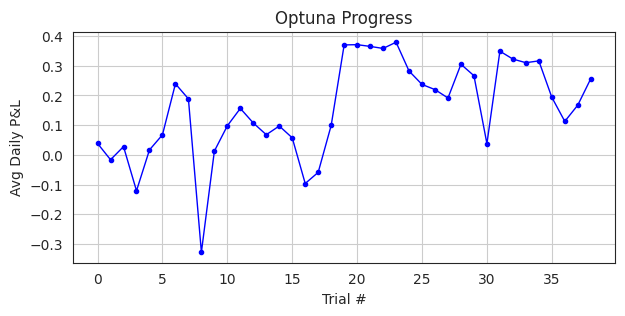

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:03:34,790] Trial 1 finished with value: -0.016243148148148156 and parameters: {'look_back': 30, 'min_prof_thr': 0.023869262898136363, 'max_down_prop': 0.05593614692207797, 'gain_tightening_factor': 1.3367458636064589, 'merging_retracement_thr': 0.09800098166712427, 'merging_time_gap_thr': 0.5493403872341702, 'pre_entry_decay': 0.35938771255007274, 'short_penal_decay': 2.907572495174129, 'trailing_stop_pct': 0.1211845613799968, 'buy_threshold': 0.7956578609945447, 'top_percentile': 8.58610965588295, 'smoothing_window': 2}. Best is trial 0 with value: 0.038515370370370366.


→ Total return across 5400 trading days: $-87.71
→ Avg daily return (all days)          : $-0.0162
→ Total trades                          : 59439
→ Avg return per trade                  : $-0.0015

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:06:22,942] Trial 2 finished with value: 0.027945370370370367 and parameters: {'look_back': 90, 'min_prof_thr': 0.08374101394526068, 'max_down_prop': 0.08662767941871433, 'gain_tightening_factor': 0.8349311035448646, 'merging_retracement_thr': 0.049657619633136495, 'merging_time_gap_thr': 0.5050644938542572, 'pre_entry_decay': 0.3485603031187574, 'short_penal_decay': 2.279759527567937, 'trailing_stop_pct': 0.6588423551113594, 'buy_threshold': 0.8976891807458741, 'top_percentile': 10.676455132015908, 'smoothing_window': 2}. Best is trial 0 with value: 0.038515370370370366.


→ Total return across 5400 trading days: $150.90
→ Avg daily return (all days)          : $0.0279
→ Total trades                          : 18770
→ Avg return per trade                  : $0.0080

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:08:44,137] Trial 3 finished with value: -0.12071296296296295 and parameters: {'look_back': 30, 'min_prof_thr': 0.010927438438725241, 'max_down_prop': 0.09900455056076368, 'gain_tightening_factor': 2.0248449051822726, 'merging_retracement_thr': 0.09035803927259109, 'merging_time_gap_thr': 0.9375032507055725, 'pre_entry_decay': 0.41103533493784317, 'short_penal_decay': 1.1378547466162339, 'trailing_stop_pct': 0.5974994789173124, 'buy_threshold': 0.32892222205644495, 'top_percentile': 8.482705343786066, 'smoothing_window': 3}. Best is trial 0 with value: 0.038515370370370366.


→ Total return across 5400 trading days: $-651.85
→ Avg daily return (all days)          : $-0.1207
→ Total trades                          : 19670
→ Avg return per trade                  : $-0.0331

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:11:07,429] Trial 4 finished with value: 0.01683166666666667 and parameters: {'look_back': 60, 'min_prof_thr': 0.08355421169558779, 'max_down_prop': 0.08588757738299115, 'gain_tightening_factor': 0.4265298344015511, 'merging_retracement_thr': 0.05788383534826823, 'merging_time_gap_thr': 0.3520775086904296, 'pre_entry_decay': 0.10947846215820026, 'short_penal_decay': 2.2676802614967597, 'trailing_stop_pct': 0.3832899401094765, 'buy_threshold': 0.32677815921962655, 'top_percentile': 7.717376802120892, 'smoothing_window': 3}. Best is trial 0 with value: 0.038515370370370366.


→ Total return across 5400 trading days: $90.89
→ Avg daily return (all days)          : $0.0168
→ Total trades                          : 25214
→ Avg return per trade                  : $0.0036

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:14:07,602] Trial 5 finished with value: 0.06763648148148148 and parameters: {'look_back': 150, 'min_prof_thr': 0.1512939934260902, 'max_down_prop': 0.09521705968499379, 'gain_tightening_factor': 2.2015169601751796, 'merging_retracement_thr': 0.02387518920784919, 'merging_time_gap_thr': 0.8365416640844865, 'pre_entry_decay': 0.1537412312354235, 'short_penal_decay': 1.3925089410582365, 'trailing_stop_pct': 0.426561021727919, 'buy_threshold': 0.5858501677153131, 'top_percentile': 19.486007122234188, 'smoothing_window': 2}. Best is trial 5 with value: 0.06763648148148148.


→ Total return across 5400 trading days: $365.24
→ Avg daily return (all days)          : $0.0676
→ Total trades                          : 23664
→ Avg return per trade                  : $0.0154

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:16:56,192] Trial 6 finished with value: 0.23931962962962963 and parameters: {'look_back': 150, 'min_prof_thr': 0.10989478407566859, 'max_down_prop': 0.054032982320028, 'gain_tightening_factor': 0.9104234421833546, 'merging_retracement_thr': 0.08679173732127589, 'merging_time_gap_thr': 0.5711744530702083, 'pre_entry_decay': 0.12236275241174131, 'short_penal_decay': 1.179080729873996, 'trailing_stop_pct': 0.38163276195726903, 'buy_threshold': 0.5125854517252403, 'top_percentile': 2.3097728114873712, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $1292.33
→ Avg daily return (all days)          : $0.2393
→ Total trades                          : 25055
→ Avg return per trade                  : $0.0516

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:19:15,885] Trial 7 finished with value: 0.18865351851851853 and parameters: {'look_back': 90, 'min_prof_thr': 0.18902962605801155, 'max_down_prop': 0.030909197908296805, 'gain_tightening_factor': 1.7539311159401758, 'merging_retracement_thr': 0.07373261831105687, 'merging_time_gap_thr': 0.6194421442505522, 'pre_entry_decay': 0.4739539924487671, 'short_penal_decay': 1.9515481486792567, 'trailing_stop_pct': 0.21742305562732367, 'buy_threshold': 0.10320580283774833, 'top_percentile': 5.813906332874939, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $1018.73
→ Avg daily return (all days)          : $0.1887
→ Total trades                          : 36184
→ Avg return per trade                  : $0.0282

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:22:13,815] Trial 8 finished with value: -0.3275107407407407 and parameters: {'look_back': 150, 'min_prof_thr': 0.047998348761938606, 'max_down_prop': 0.04255388342055074, 'gain_tightening_factor': 2.6335470126317944, 'merging_retracement_thr': 0.022635490323600124, 'merging_time_gap_thr': 0.46502197437179427, 'pre_entry_decay': 0.497666669238516, 'short_penal_decay': 2.2966751804792893, 'trailing_stop_pct': 0.08118871097406652, 'buy_threshold': 0.05430521962116053, 'top_percentile': 14.493465486277618, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $-1768.56
→ Avg daily return (all days)          : $-0.3275
→ Total trades                          : 82008
→ Avg return per trade                  : $-0.0216

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:25:04,551] Trial 9 finished with value: 0.012789629629629621 and parameters: {'look_back': 120, 'min_prof_thr': 0.1112810180722859, 'max_down_prop': 0.037554556200314074, 'gain_tightening_factor': 0.7580326634091974, 'merging_retracement_thr': 0.07317113962980613, 'merging_time_gap_thr': 0.9682649471276001, 'pre_entry_decay': 0.2715595611320223, 'short_penal_decay': 1.792238289321174, 'trailing_stop_pct': 0.18039730502025558, 'buy_threshold': 0.3202907383081203, 'top_percentile': 9.423247799131856, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $69.06
→ Avg daily return (all days)          : $0.0128
→ Total trades                          : 54040
→ Avg return per trade                  : $0.0013

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:27:54,436] Trial 10 finished with value: 0.09792796296296297 and parameters: {'look_back': 150, 'min_prof_thr': 0.1930562978935746, 'max_down_prop': 0.014800652321034669, 'gain_tightening_factor': 1.3325205950162986, 'merging_retracement_thr': 0.07952431348701818, 'merging_time_gap_thr': 0.20093752115484792, 'pre_entry_decay': 0.23442507366775367, 'short_penal_decay': 0.3218300720666365, 'trailing_stop_pct': 0.8797033865755111, 'buy_threshold': 0.6016055452626557, 'top_percentile': 1.3032924347512276, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $528.81
→ Avg daily return (all days)          : $0.0979
→ Total trades                          : 12139
→ Avg return per trade                  : $0.0436

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:30:12,418] Trial 11 finished with value: 0.15645092592592594 and parameters: {'look_back': 90, 'min_prof_thr': 0.1972816111977636, 'max_down_prop': 0.06016224087286287, 'gain_tightening_factor': 1.670974306502735, 'merging_retracement_thr': 0.07071090045017396, 'merging_time_gap_thr': 0.6658027740054228, 'pre_entry_decay': 0.20098268953009374, 'short_penal_decay': 0.7647025149685234, 'trailing_stop_pct': 0.31759635071267267, 'buy_threshold': 0.04943779851438096, 'top_percentile': 3.867134090496627, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $844.84
→ Avg daily return (all days)          : $0.1565
→ Total trades                          : 22672
→ Avg return per trade                  : $0.0373

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:32:30,341] Trial 12 finished with value: 0.10745407407407406 and parameters: {'look_back': 90, 'min_prof_thr': 0.16199761316254363, 'max_down_prop': 0.022157158503751447, 'gain_tightening_factor': 1.2768129409713984, 'merging_retracement_thr': 0.08371908892052037, 'merging_time_gap_thr': 0.6651705951403819, 'pre_entry_decay': 0.3004433301192895, 'short_penal_decay': 1.7888704281600076, 'trailing_stop_pct': 0.5446819821638045, 'buy_threshold': 0.5138936594875452, 'top_percentile': 5.572286964275967, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $580.25
→ Avg daily return (all days)          : $0.1075
→ Total trades                          : 21151
→ Avg return per trade                  : $0.0274

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:35:03,857] Trial 13 finished with value: 0.06792740740740741 and parameters: {'look_back': 120, 'min_prof_thr': 0.11337313767306893, 'max_down_prop': 0.06620971009111287, 'gain_tightening_factor': 1.8938077835659228, 'merging_retracement_thr': 0.06340242086491245, 'merging_time_gap_thr': 0.3873826584260489, 'pre_entry_decay': 0.10183411179082709, 'short_penal_decay': 0.8682969433139613, 'trailing_stop_pct': 0.24762128413348114, 'buy_threshold': 0.18355171324137992, 'top_percentile': 5.884887794065827, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $366.81
→ Avg daily return (all days)          : $0.0679
→ Total trades                          : 32487
→ Avg return per trade                  : $0.0113

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:37:06,764] Trial 14 finished with value: 0.09727518518518517 and parameters: {'look_back': 60, 'min_prof_thr': 0.1730446474954248, 'max_down_prop': 0.03493023613466646, 'gain_tightening_factor': 0.951643500049203, 'merging_retracement_thr': 0.09979015959109161, 'merging_time_gap_thr': 0.6551111528022007, 'pre_entry_decay': 0.39278003642416653, 'short_penal_decay': 1.9389840862588965, 'trailing_stop_pct': 0.7027308090133113, 'buy_threshold': 0.6851625674225479, 'top_percentile': 1.281869170125767, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $525.29
→ Avg daily return (all days)          : $0.0973
→ Total trades                          : 12755
→ Avg return per trade                  : $0.0412

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:39:56,361] Trial 15 finished with value: 0.05751962962962963 and parameters: {'look_back': 150, 'min_prof_thr': 0.05953901093798697, 'max_down_prop': 0.07191941350189332, 'gain_tightening_factor': 0.40794596337860267, 'merging_retracement_thr': 0.08430014259288889, 'merging_time_gap_thr': 0.7809787364841849, 'pre_entry_decay': 0.19129473540324832, 'short_penal_decay': 2.9560120876285474, 'trailing_stop_pct': 0.4760835450991378, 'buy_threshold': 0.4566478335763014, 'top_percentile': 12.08531718264992, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $310.61
→ Avg daily return (all days)          : $0.0575
→ Total trades                          : 22362
→ Avg return per trade                  : $0.0139

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:42:13,789] Trial 16 finished with value: -0.0962588888888889 and parameters: {'look_back': 90, 'min_prof_thr': 0.1329124439181396, 'max_down_prop': 0.047729717668645165, 'gain_tightening_factor': 2.4816347391716818, 'merging_retracement_thr': 0.03757644670200262, 'merging_time_gap_thr': 0.5976222648584123, 'pre_entry_decay': 0.4490414263642386, 'short_penal_decay': 1.4687542562290705, 'trailing_stop_pct': 0.3548285348580855, 'buy_threshold': 0.19146019696179667, 'top_percentile': 4.8607206005136945, 'smoothing_window': 3}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $-519.80
→ Avg daily return (all days)          : $-0.0963
→ Total trades                          : 31444
→ Avg return per trade                  : $-0.0165

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:44:35,895] Trial 17 finished with value: -0.058695555555555556 and parameters: {'look_back': 90, 'min_prof_thr': 0.08085498780082401, 'max_down_prop': 0.025839249528899846, 'gain_tightening_factor': 1.629126599564306, 'merging_retracement_thr': 0.06447307065304003, 'merging_time_gap_thr': 0.40095630728285214, 'pre_entry_decay': 0.3081361939316474, 'short_penal_decay': 0.9555036893117667, 'trailing_stop_pct': 0.2267273411151302, 'buy_threshold': 0.2094074114466365, 'top_percentile': 6.658347171476411, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $-316.96
→ Avg daily return (all days)          : $-0.0587
→ Total trades                          : 47384
→ Avg return per trade                  : $-0.0067

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:47:18,622] Trial 18 finished with value: 0.09913981481481482 and parameters: {'look_back': 150, 'min_prof_thr': 0.18098571378584985, 'max_down_prop': 0.029080286197681576, 'gain_tightening_factor': 1.0493744548182358, 'merging_retracement_thr': 0.010372494118236923, 'merging_time_gap_thr': 0.7584990115584351, 'pre_entry_decay': 0.2345295625768154, 'short_penal_decay': 0.5303461070161167, 'trailing_stop_pct': 0.5107800910364799, 'buy_threshold': 0.38683717491959996, 'top_percentile': 15.122337816976588, 'smoothing_window': 1}. Best is trial 6 with value: 0.23931962962962963.


→ Total return across 5400 trading days: $535.36
→ Avg daily return (all days)          : $0.0991
→ Total trades                          : 18353
→ Avg return per trade                  : $0.0292

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:49:20,322] Trial 19 finished with value: 0.3701135185185185 and parameters: {'look_back': 60, 'min_prof_thr': 0.1356101874492359, 'max_down_prop': 0.010583026663381442, 'gain_tightening_factor': 1.6132431345632634, 'merging_retracement_thr': 0.07631461885207715, 'merging_time_gap_thr': 0.29338552778282667, 'pre_entry_decay': 0.15616047712911357, 'short_penal_decay': 2.5662672159697557, 'trailing_stop_pct': 0.03868467236993117, 'buy_threshold': 0.6752716626646638, 'top_percentile': 3.772316473614083, 'smoothing_window': 3}. Best is trial 19 with value: 0.3701135185185185.


→ Total return across 5400 trading days: $1998.61
→ Avg daily return (all days)          : $0.3701
→ Total trades                          : 31201
→ Avg return per trade                  : $0.0641

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:51:20,675] Trial 20 finished with value: 0.37100314814814817 and parameters: {'look_back': 60, 'min_prof_thr': 0.13308844845139095, 'max_down_prop': 0.012024973695195581, 'gain_tightening_factor': 0.6463187619209896, 'merging_retracement_thr': 0.09088500182280516, 'merging_time_gap_thr': 0.201374836517515, 'pre_entry_decay': 0.15694507236309987, 'short_penal_decay': 2.549670689736816, 'trailing_stop_pct': 0.030799753501166045, 'buy_threshold': 0.6718257616716687, 'top_percentile': 2.8210134073469053, 'smoothing_window': 3}. Best is trial 20 with value: 0.37100314814814817.


→ Total return across 5400 trading days: $2003.42
→ Avg daily return (all days)          : $0.3710
→ Total trades                          : 25850
→ Avg return per trade                  : $0.0775

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:53:22,178] Trial 21 finished with value: 0.3651542592592592 and parameters: {'look_back': 60, 'min_prof_thr': 0.12901825651781224, 'max_down_prop': 0.013257022262108318, 'gain_tightening_factor': 0.6217727751040136, 'merging_retracement_thr': 0.08790502832478593, 'merging_time_gap_thr': 0.23637338635461108, 'pre_entry_decay': 0.14782236585954026, 'short_penal_decay': 2.6445302862740747, 'trailing_stop_pct': 0.033450809314062004, 'buy_threshold': 0.7384604624934398, 'top_percentile': 3.0836035347091633, 'smoothing_window': 3}. Best is trial 20 with value: 0.37100314814814817.


→ Total return across 5400 trading days: $1971.83
→ Avg daily return (all days)          : $0.3652
→ Total trades                          : 22727
→ Avg return per trade                  : $0.0868

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:55:22,759] Trial 22 finished with value: 0.3582518518518519 and parameters: {'look_back': 60, 'min_prof_thr': 0.13536892311261428, 'max_down_prop': 0.013625105462296784, 'gain_tightening_factor': 0.6134463995399874, 'merging_retracement_thr': 0.09306794819324957, 'merging_time_gap_thr': 0.21744408900346254, 'pre_entry_decay': 0.17114732808787927, 'short_penal_decay': 2.5534624336689644, 'trailing_stop_pct': 0.054272447060648335, 'buy_threshold': 0.7396289977547589, 'top_percentile': 3.630000107071033, 'smoothing_window': 3}. Best is trial 20 with value: 0.37100314814814817.


→ Total return across 5400 trading days: $1934.56
→ Avg daily return (all days)          : $0.3583
→ Total trades                          : 27448
→ Avg return per trade                  : $0.0705

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:57:22,511] Trial 23 finished with value: 0.3792037037037037 and parameters: {'look_back': 60, 'min_prof_thr': 0.14936641099166223, 'max_down_prop': 0.01052225424215529, 'gain_tightening_factor': 0.5299213071977746, 'merging_retracement_thr': 0.07830451763395935, 'merging_time_gap_thr': 0.30206728730433513, 'pre_entry_decay': 0.1392263403515707, 'short_penal_decay': 2.6893668778672706, 'trailing_stop_pct': 0.032860909981238286, 'buy_threshold': 0.6971635060500512, 'top_percentile': 3.916913617121738, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $2047.70
→ Avg daily return (all days)          : $0.3792
→ Total trades                          : 28521
→ Avg return per trade                  : $0.0718

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 14:59:24,361] Trial 24 finished with value: 0.28228388888888895 and parameters: {'look_back': 60, 'min_prof_thr': 0.15882545938351372, 'max_down_prop': 0.02069087111428391, 'gain_tightening_factor': 0.33186791210641897, 'merging_retracement_thr': 0.07726725667614517, 'merging_time_gap_thr': 0.30047143085916844, 'pre_entry_decay': 0.2244459437194885, 'short_penal_decay': 2.6312403372818345, 'trailing_stop_pct': 0.14131359810844496, 'buy_threshold': 0.6645806117805421, 'top_percentile': 3.9952615211125524, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1524.33
→ Avg daily return (all days)          : $0.2823
→ Total trades                          : 34191
→ Avg return per trade                  : $0.0446

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:01:34,328] Trial 25 finished with value: 0.23707537037037038 and parameters: {'look_back': 60, 'min_prof_thr': 0.1487350957228228, 'max_down_prop': 0.01115456166927001, 'gain_tightening_factor': 1.1367100566364465, 'merging_retracement_thr': 0.0649898768314653, 'merging_time_gap_thr': 0.29392926069250314, 'pre_entry_decay': 0.14926605385359326, 'short_penal_decay': 2.482802228596092, 'trailing_stop_pct': 0.13151325501642241, 'buy_threshold': 0.8117883196102116, 'top_percentile': 1.1394315789819487, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1280.21
→ Avg daily return (all days)          : $0.2371
→ Total trades                          : 8532
→ Avg return per trade                  : $0.1500

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:03:42,740] Trial 26 finished with value: 0.21974 and parameters: {'look_back': 60, 'min_prof_thr': 0.12316753883079996, 'max_down_prop': 0.020054193914471028, 'gain_tightening_factor': 1.4527275111223656, 'merging_retracement_thr': 0.07994200451036429, 'merging_time_gap_thr': 0.2797698776907244, 'pre_entry_decay': 0.19752957279572245, 'short_penal_decay': 2.860051162448765, 'trailing_stop_pct': 0.036110917975156184, 'buy_threshold': 0.5922077000681382, 'top_percentile': 7.191711152734504, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1186.60
→ Avg daily return (all days)          : $0.2197
→ Total trades                          : 57305
→ Avg return per trade                  : $0.0207

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:05:47,588] Trial 27 finished with value: 0.19150611111111113 and parameters: {'look_back': 60, 'min_prof_thr': 0.09460675617350697, 'max_down_prop': 0.017973032604539828, 'gain_tightening_factor': 0.590747424731582, 'merging_retracement_thr': 0.09530015158601007, 'merging_time_gap_thr': 0.4312397402906923, 'pre_entry_decay': 0.26553116681512107, 'short_penal_decay': 2.0827920970884, 'trailing_stop_pct': 0.14992621101557446, 'buy_threshold': 0.6615988493983522, 'top_percentile': 4.551966012623622, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1034.13
→ Avg daily return (all days)          : $0.1915
→ Total trades                          : 40610
→ Avg return per trade                  : $0.0255

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:07:50,325] Trial 28 finished with value: 0.3050038888888889 and parameters: {'look_back': 60, 'min_prof_thr': 0.16897503891099713, 'max_down_prop': 0.024836196905910064, 'gain_tightening_factor': 2.2956982827114434, 'merging_retracement_thr': 0.05926951608060768, 'merging_time_gap_thr': 0.3249966297531857, 'pre_entry_decay': 0.13135726644506646, 'short_penal_decay': 2.7653817520850588, 'trailing_stop_pct': 0.10428991696351139, 'buy_threshold': 0.8050495012231714, 'top_percentile': 10.79992962295956, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1647.02
→ Avg daily return (all days)          : $0.3050
→ Total trades                          : 40581
→ Avg return per trade                  : $0.0406

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:09:52,845] Trial 29 finished with value: 0.26650888888888885 and parameters: {'look_back': 60, 'min_prof_thr': 0.14881880662314334, 'max_down_prop': 0.01040401185931796, 'gain_tightening_factor': 2.8001266470143857, 'merging_retracement_thr': 0.04618808986583229, 'merging_time_gap_thr': 0.26326854298408314, 'pre_entry_decay': 0.17070156543501214, 'short_penal_decay': 2.484555484756985, 'trailing_stop_pct': 0.2970439821290807, 'buy_threshold': 0.732801379422689, 'top_percentile': 2.5780084165610893, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1439.15
→ Avg daily return (all days)          : $0.2665
→ Total trades                          : 17346
→ Avg return per trade                  : $0.0830

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:11:57,635] Trial 30 finished with value: 0.037991666666666674 and parameters: {'look_back': 60, 'min_prof_thr': 0.14348923587880952, 'max_down_prop': 0.04269451998341043, 'gain_tightening_factor': 1.1274937785266719, 'merging_retracement_thr': 0.06941937227514619, 'merging_time_gap_thr': 0.3499051396739698, 'pre_entry_decay': 0.17290021572952644, 'short_penal_decay': 2.190660068342036, 'trailing_stop_pct': 0.20965017806918082, 'buy_threshold': 0.5216335383746253, 'top_percentile': 19.882486508910983, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $205.16
→ Avg daily return (all days)          : $0.0380
→ Total trades                          : 38858
→ Avg return per trade                  : $0.0053

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:13:59,997] Trial 31 finished with value: 0.3490737037037037 and parameters: {'look_back': 60, 'min_prof_thr': 0.12343533658940603, 'max_down_prop': 0.01587712492597188, 'gain_tightening_factor': 0.5734549335403651, 'merging_retracement_thr': 0.09017190413966764, 'merging_time_gap_thr': 0.2448257626131239, 'pre_entry_decay': 0.13734401165402157, 'short_penal_decay': 2.687471123728644, 'trailing_stop_pct': 0.04020473010256495, 'buy_threshold': 0.7400857680203815, 'top_percentile': 2.6553603248930426, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1885.00
→ Avg daily return (all days)          : $0.3491
→ Total trades                          : 19407
→ Avg return per trade                  : $0.0971

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:15:47,926] Trial 32 finished with value: 0.3225472222222222 and parameters: {'look_back': 30, 'min_prof_thr': 0.13201071487418586, 'max_down_prop': 0.017134978375910083, 'gain_tightening_factor': 0.7482563970897943, 'merging_retracement_thr': 0.08699454850912568, 'merging_time_gap_thr': 0.20719888732888989, 'pre_entry_decay': 0.15257952827287624, 'short_penal_decay': 2.987524330032676, 'trailing_stop_pct': 0.031546411586334276, 'buy_threshold': 0.8480159901517017, 'top_percentile': 2.826403938126944, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1741.75
→ Avg daily return (all days)          : $0.3225
→ Total trades                          : 15766
→ Avg return per trade                  : $0.1105

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:17:52,629] Trial 33 finished with value: 0.31028462962962966 and parameters: {'look_back': 60, 'min_prof_thr': 0.09665678610569264, 'max_down_prop': 0.02869940510714151, 'gain_tightening_factor': 0.5366155472027188, 'merging_retracement_thr': 0.08054149471567199, 'merging_time_gap_thr': 0.48534167337224693, 'pre_entry_decay': 0.21409529703528102, 'short_penal_decay': 2.390214084191064, 'trailing_stop_pct': 0.09469015883107387, 'buy_threshold': 0.7009632325722229, 'top_percentile': 4.788890779641849, 'smoothing_window': 2}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1675.54
→ Avg daily return (all days)          : $0.3103
→ Total trades                          : 43764
→ Avg return per trade                  : $0.0383

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:19:53,879] Trial 34 finished with value: 0.3164107407407407 and parameters: {'look_back': 60, 'min_prof_thr': 0.12450680083391505, 'max_down_prop': 0.010714473334525078, 'gain_tightening_factor': 0.7255789073053254, 'merging_retracement_thr': 0.09395518324836163, 'merging_time_gap_thr': 0.24933552279105445, 'pre_entry_decay': 0.10381709796970648, 'short_penal_decay': 2.7997764921372807, 'trailing_stop_pct': 0.16796003235391685, 'buy_threshold': 0.8657097937202358, 'top_percentile': 3.2102830061409104, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1708.62
→ Avg daily return (all days)          : $0.3164
→ Total trades                          : 13573
→ Avg return per trade                  : $0.1259

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:21:43,489] Trial 35 finished with value: 0.19397296296296296 and parameters: {'look_back': 30, 'min_prof_thr': 0.14094315591879925, 'max_down_prop': 0.034766043907924114, 'gain_tightening_factor': 0.34534840475777684, 'merging_retracement_thr': 0.05247845397374349, 'merging_time_gap_thr': 0.36238697273180975, 'pre_entry_decay': 0.254774663847047, 'short_penal_decay': 2.6583802066985234, 'trailing_stop_pct': 0.09628978429191828, 'buy_threshold': 0.6267948994460915, 'top_percentile': 6.49027631662608, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1047.45
→ Avg daily return (all days)          : $0.1940
→ Total trades                          : 51346
→ Avg return per trade                  : $0.0204

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:24:11,140] Trial 36 finished with value: 0.11285166666666668 and parameters: {'look_back': 120, 'min_prof_thr': 0.15767887756731863, 'max_down_prop': 0.02430918915186911, 'gain_tightening_factor': 0.9055246299378736, 'merging_retracement_thr': 0.08900051532701206, 'merging_time_gap_thr': 0.5198583837546495, 'pre_entry_decay': 0.34023434686484655, 'short_penal_decay': 2.3799424346870985, 'trailing_stop_pct': 0.08308359700307305, 'buy_threshold': 0.7727660547780669, 'top_percentile': 8.418427936330563, 'smoothing_window': 2}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $609.40
→ Avg daily return (all days)          : $0.1129
→ Total trades                          : 65025
→ Avg return per trade                  : $0.0094

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:26:17,842] Trial 37 finished with value: 0.16739481481481483 and parameters: {'look_back': 60, 'min_prof_thr': 0.09957824048248312, 'max_down_prop': 0.08129914708842267, 'gain_tightening_factor': 0.4871742574960807, 'merging_retracement_thr': 0.0973699246359577, 'merging_time_gap_thr': 0.31961470241332157, 'pre_entry_decay': 0.1255685838259905, 'short_penal_decay': 2.168906263646214, 'trailing_stop_pct': 0.7697942121045627, 'buy_threshold': 0.5634836827822429, 'top_percentile': 2.197060346309577, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $903.93
→ Avg daily return (all days)          : $0.1674
→ Total trades                          : 11670
→ Avg return per trade                  : $0.0775

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-18 15:28:21,893] Trial 38 finished with value: 0.2562240740740741 and parameters: {'look_back': 60, 'min_prof_thr': 0.12088293355749286, 'max_down_prop': 0.01016316360375126, 'gain_tightening_factor': 2.0574699885380197, 'merging_retracement_thr': 0.07525726683160128, 'merging_time_gap_thr': 0.4184127933597188, 'pre_entry_decay': 0.18036264253628337, 'short_penal_decay': 2.5573128461975414, 'trailing_stop_pct': 0.18097904717877553, 'buy_threshold': 0.6373571866299919, 'top_percentile': 5.10453717836595, 'smoothing_window': 3}. Best is trial 23 with value: 0.3792037037037037.


→ Total return across 5400 trading days: $1383.61
→ Avg daily return (all days)          : $0.2562
→ Total trades                          : 34845
→ Avg return per trade                  : $0.0397

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{ticker}_all.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
